# Multi-Agent Applications: Building Investment Agent Teams with LangGraph

In this notebook, we'll explore **multi-agent systems** - applications where multiple specialized agents collaborate to solve complex tasks. We'll build on our LangGraph foundation from Module 4 and create agent teams for our Stone Ridge Investment Advisory Team.

**Learning Objectives:**
- Understand when and why to use multi-agent systems
- Master the Supervisor pattern for orchestrating investment agent teams
- Implement Agent Handoffs for dynamic task routing across investment domains
- Use Tavily Search for web research on current market data
- Apply context engineering principles to optimize agent performance with financial information
- Visualize and debug multi-agent systems with LangSmith

## Table of Contents:

- **Breakout Room #1:** Multi-Agent Fundamentals & Supervisor Pattern
  - Task 1: Dependencies & Environment Setup
  - Task 2: Understanding Multi-Agent Systems
  - Task 3: Building a Supervisor Agent Pattern
  - Task 4: Adding Tavily Search for Web Research
  - Question #1 & Question #2
  - Activity #1: Add a Custom Investment Specialist Agent

- **Breakout Room #2:** Handoffs & Context Engineering
  - Task 5: Agent Handoffs Pattern
  - Task 6: Building an Investment Agent Team
  - Task 7: Context Engineering & Optimization
  - Task 8: Visualizing and Debugging with LangSmith
  - Question #3 & Question #4
  - Activity #2: Implement Hierarchical Teams

---
# 🤝 Breakout Room #1
## Multi-Agent Fundamentals & Supervisor Pattern

## Task 1: Dependencies & Environment Setup

Before we begin, make sure you have:

1. **API Keys** for:
   - OpenAI (for GPT-5.2 supervisor and GPT-4o-mini specialist agents)
   - Tavily (free tier at [tavily.com](https://www.tavily.com/))
   - LangSmith (optional, for tracing)

2. **Dependencies installed** via `uv sync`

**Models Used:**
- **GPT-5.2**: Supervisor/orchestrator agents (better reasoning for routing decisions)
- **GPT-4o-mini**: Specialist agents (cost-effective for domain-specific tasks)

**Documentation:**
- [Tavily Search API](https://docs.tavily.com/)

In [ ]:
# Core imports
import os
import getpass
import json
from uuid import uuid4
from typing import Annotated, TypedDict, Literal, Sequence
import operator

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

In [ ]:
# Set API Keys
os.environ["OPENAI_API_KEY"] = ""

In [ ]:
# Tavily API Key for web search
os.environ["TAVILY_API_KEY"] = ""

In [ ]:
# Optional: LangSmith for tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE9 - Multi-Agent Investment Applications - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key (press Enter to skip): ") or ""

if not os.environ["LANGCHAIN_API_KEY"]:
    os.environ["LANGCHAIN_TRACING_V2"] = "false"
    print("LangSmith tracing disabled")
else:
    print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")

In [7]:
# Initialize LLMs - GPT-5.2 for supervisors, GPT-4o-mini for investment specialist agents
from langchain_openai import ChatOpenAI

# Supervisor model - better reasoning for routing and orchestration
supervisor_llm = ChatOpenAI(model="gpt-5.2", temperature=0)

# Specialist model - cost-effective for domain-specific tasks
specialist_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Test both models
print("Testing models...")
supervisor_response = supervisor_llm.invoke("Say 'Supervisor ready!' in exactly 2 words.")
specialist_response = specialist_llm.invoke("Say 'Specialist ready!' in exactly 2 words.")

print(f"Supervisor (GPT-5.2): {supervisor_response.content}")
print(f"Specialist (GPT-4o-mini): {specialist_response.content}")

Testing models...
Supervisor (GPT-5.2): Supervisor ready!
Specialist (GPT-4o-mini): Specialist ready!


## Task 2: Understanding Multi-Agent Systems

### When to Use Multi-Agent Systems

Before building multi-agent systems, ask yourself:

> **"Do I really need several specialized dynamic reasoning machines collaborating to solve this task more effectively than a single agent could?"**

Multi-agent systems are useful when:
1. **Tool/responsibility grouping**: Different tasks require different expertise
2. **Prompt separation**: Different agents need different instructions/few-shot examples
3. **Piecewise optimization**: Easier to improve individual components

### Key Multi-Agent Patterns

| Pattern | Description | Use Case |
|---------|-------------|----------|
| **Supervisor** | Central orchestrator routes to specialist agents | Task delegation, quality control |
| **Handoffs** | Agents transfer control to each other | Conversation flows, expertise routing |
| **Hierarchical** | Supervisors manage teams of agents | Large-scale systems, departments |
| **Network/Swarm** | Agents communicate freely | Collaborative problem-solving |

### Context Engineering Principles

From leading practitioners:

- **Dex Horthy (12-Factor Agents)**: "Own your context window and treat it like prime real estate"
- **swyx (Agent Engineering)**: "Agent reliability = great context construction"
- **Chroma (Context Rot)**: "Longer ≠ better when it comes to context"

**Documentation:**
- [Building Effective Agents (Anthropic)](https://www.anthropic.com/engineering/building-effective-agents)
- [Don't Build Multi-Agents (Cognition)](https://cognition.ai/blog/dont-build-multi-agents)
- [12-Factor Agents](https://github.com/humanlayer/12-factor-agents)

## Task 3: Building a Supervisor Agent Pattern

The **Supervisor Pattern** uses a central agent to:
1. Analyze incoming requests
2. Route to the appropriate specialist agent
3. Aggregate and refine responses

```
                    ┌─────────────────┐
                    │   Supervisor    │
                    │   (Orchestrator)│
                    └────────┬────────┘
                             │
    ┌────────────────────────┼────────────────────────┐
    │                        │                        │
    ▼                        ▼                        ▼
┌──────────────┐    ┌──────────────────┐    ┌──────────────┐
│Market Outlook│    │   Investment     │    │    Risk      │
│    Agent     │    │ Strategy Agent   │    │ Management   │
└──────────────┘    └──────────────────┘    │    Agent     │
                                            └──────────────┘
```

We'll build an **investment advisory team** where a supervisor routes user questions to the appropriate investment specialist.

**Documentation:**
- [LangGraph Supervisor Tutorial](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/)

In [8]:
# Import LangGraph and LangChain components
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.agents import create_agent  # LangChain 1.0 API
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langchain_core.tools import tool

print("LangGraph and LangChain components imported!")

LangGraph and LangChain components imported!


In [9]:
# First, let's set up our RAG system for the investment knowledge base
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# Load and chunk the investor letter
loader = PyMuPDFLoader("data/Stone Ridge 2025 Investor Letter.pdf")
documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100
)
chunks = text_splitter.split_documents(documents)

print(f"Loaded and split into {len(chunks)} chunks")

Loaded and split into 127 chunks


In [10]:
# Set up vector store for investment knowledge base
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
embedding_dim = len(embedding_model.embed_query("test"))

qdrant_client = QdrantClient(":memory:")
qdrant_client.create_collection(
    collection_name="investment_multiagent",
    vectors_config=VectorParams(size=embedding_dim, distance=Distance.COSINE)
)

vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name="investment_multiagent",
    embedding=embedding_model
)
vector_store.add_documents(chunks)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})
print(f"Vector store ready with {len(chunks)} investment documents")

Vector store ready with 127 investment documents


In [11]:
# Create specialized tools for each investment agent domain

@tool
def search_market_outlook(query: str) -> str:
    """Search for market trends, economic conditions, and macro outlook from the Stone Ridge investor letter.
    Use this for questions about market environment, economic forecasts, and market analysis.
    """
    results = retriever.invoke(f"market trends economic conditions macro {query}")
    if not results:
        return "No market outlook information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_investment_strategy(query: str) -> str:
    """Search for investment strategy, portfolio positioning, and asset allocation information from the Stone Ridge investor letter.
    Use this for questions about investment approach, portfolio construction, and strategic decisions.
    """
    results = retriever.invoke(f"investment strategy portfolio allocation positioning {query}")
    if not results:
        return "No investment strategy information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_risk_info(query: str) -> str:
    """Search for risk management, tail risk, and diversification information from the Stone Ridge investor letter.
    Use this for questions about risk factors, hedging strategies, and risk mitigation.
    """
    results = retriever.invoke(f"risk management tail risk hedging diversification {query}")
    if not results:
        return "No risk management information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_performance_info(query: str) -> str:
    """Search for performance data, returns, and benchmark information from the Stone Ridge investor letter.
    Use this for questions about investment returns, performance metrics, and historical results.
    """
    results = retriever.invoke(f"performance returns benchmark CAGR historical results {query}")
    if not results:
        return "No performance information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

print("Investment specialist tools created!")

Investment specialist tools created!


In [12]:
# Create investment specialist agents using create_agent (LangChain 1.0 API)
# Each specialist uses GPT-4o-mini for cost efficiency

market_outlook_agent = create_agent(
    model=specialist_llm,
    tools=[search_market_outlook],
    system_prompt="You are a Market Outlook Specialist. Help users understand market trends, economic conditions, and the macro environment. Always search the knowledge base before answering. Be concise and data-driven."
)

investment_strategy_agent = create_agent(
    model=specialist_llm,
    tools=[search_investment_strategy],
    system_prompt="You are an Investment Strategy Specialist. Help users with portfolio positioning, asset allocation, and investment philosophy. Always search the knowledge base before answering. Be concise and data-driven."
)

risk_management_agent = create_agent(
    model=specialist_llm,
    tools=[search_risk_info],
    system_prompt="You are a Risk Management Specialist. Help users understand risk factors, tail risks, hedging strategies, and diversification. Always search the knowledge base before answering. Be concise and data-driven."
)

performance_analysis_agent = create_agent(
    model=specialist_llm,
    tools=[search_performance_info],
    system_prompt="You are a Performance Analysis Specialist. Help users with investment returns, performance metrics, benchmarks, and historical data. Always search the knowledge base before answering. Be concise and data-driven."
)

print("Investment specialist agents created (using GPT-4o-mini with create_agent)!")

Investment specialist agents created (using GPT-4o-mini with create_agent)!


In [13]:
# Define the supervisor state and routing
from typing import List
from pydantic import BaseModel

# Define routing options - supervisor picks ONE specialist, then that specialist responds
class RouterOutput(BaseModel):
    """The supervisor's routing decision."""
    next: Literal["market_outlook", "investment_strategy", "risk_management", "performance_analysis"]
    reasoning: str

class SupervisorState(TypedDict):
    """State for the supervisor multi-agent system."""
    messages: Annotated[list[BaseMessage], add_messages]
    next: str

print("Supervisor state defined!")

Supervisor state defined!


In [14]:
# Create the supervisor node (using GPT-5.2 for routing decisions)
from langchain_core.prompts import ChatPromptTemplate

supervisor_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an Investment Supervisor coordinating a team of specialist agents.

Your team:
- market_outlook: Handles market trends, economic conditions, macro environment questions
- investment_strategy: Handles portfolio positioning, asset allocation, investment approach questions
- risk_management: Handles risk factors, tail risks, hedging, diversification questions
- performance_analysis: Handles returns, benchmarks, performance metrics, historical data questions

Based on the user's question, decide which ONE specialist should respond.
Choose the most relevant specialist for the primary topic of the question."""),
    ("human", "User question: {question}\n\nWhich specialist should handle this?")
])

# Create structured output for routing (using GPT-5.2)
routing_llm = supervisor_llm.with_structured_output(RouterOutput)

def supervisor_node(state: SupervisorState):
    """The supervisor decides which agent to route to."""
    # Get the user's question from the last human message
    user_question = ""
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            user_question = msg.content
            break
    
    # Get routing decision
    prompt_value = supervisor_prompt.invoke({"question": user_question})
    result = routing_llm.invoke(prompt_value)
    
    print(f"[Supervisor GPT-5.2] Routing to: {result.next}")
    print(f"  Reason: {result.reasoning}")
    
    return {"next": result.next}

print("Supervisor node created (using GPT-5.2)!")

Supervisor node created (using GPT-5.2)!


In [15]:
# Create agent nodes that wrap the specialist agents

def create_agent_node(agent, name: str):
    """Create a node that runs a specialist agent and returns the final response."""
    def agent_node(state: SupervisorState):
        print(f"[{name.upper()} Agent] Processing request...")
        
        # Invoke the specialist agent with the conversation
        result = agent.invoke({"messages": state["messages"]})
        
        # Get the agent's final response
        agent_response = result["messages"][-1]
        
        # Add agent identifier to the response
        response_with_name = AIMessage(
            content=f"[{name.upper()} SPECIALIST]\n\n{agent_response.content}",
            name=name
        )
        
        print(f"[{name.upper()} Agent] Response complete.")
        return {"messages": [response_with_name]}
    
    return agent_node

# Create nodes for each investment specialist
market_outlook_node = create_agent_node(market_outlook_agent, "market_outlook")
investment_strategy_node = create_agent_node(investment_strategy_agent, "investment_strategy")
risk_management_node = create_agent_node(risk_management_agent, "risk_management")
performance_analysis_node = create_agent_node(performance_analysis_agent, "performance_analysis")

print("Agent nodes created!")

Agent nodes created!


In [16]:
# Build the supervisor graph
# KEY: Specialists go directly to END (no loop back to supervisor)

def route_to_agent(state: SupervisorState) -> str:
    """Route to the next agent based on supervisor decision."""
    return state["next"]

# Create the graph
supervisor_workflow = StateGraph(SupervisorState)

# Add nodes
supervisor_workflow.add_node("supervisor", supervisor_node)
supervisor_workflow.add_node("market_outlook", market_outlook_node)
supervisor_workflow.add_node("investment_strategy", investment_strategy_node)
supervisor_workflow.add_node("risk_management", risk_management_node)
supervisor_workflow.add_node("performance_analysis", performance_analysis_node)

# Add edges: START -> supervisor
supervisor_workflow.add_edge(START, "supervisor")

# Conditional routing from supervisor to specialists
supervisor_workflow.add_conditional_edges(
    "supervisor",
    route_to_agent,
    {
        "market_outlook": "market_outlook",
        "investment_strategy": "investment_strategy",
        "risk_management": "risk_management",
        "performance_analysis": "performance_analysis",
    }
)

# KEY FIX: Each specialist goes directly to END (no looping!)
supervisor_workflow.add_edge("market_outlook", END)
supervisor_workflow.add_edge("investment_strategy", END)
supervisor_workflow.add_edge("risk_management", END)
supervisor_workflow.add_edge("performance_analysis", END)

# Compile
supervisor_graph = supervisor_workflow.compile()

print("Supervisor multi-agent system built!")
print("Flow: User -> Supervisor -> Specialist -> END")

Supervisor multi-agent system built!
Flow: User -> Supervisor -> Specialist -> END


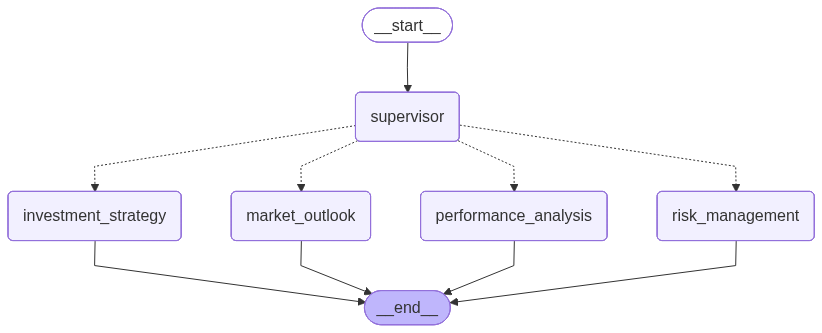

In [17]:
# Visualize the graph
try:
    from IPython.display import display, Image
    display(Image(supervisor_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(supervisor_graph.get_graph().draw_ascii())

In [18]:
# Test the supervisor system
print("Testing Supervisor Multi-Agent System")
print("=" * 50)

response = supervisor_graph.invoke({
    "messages": [HumanMessage(content="What is Stone Ridge's view on the current market environment?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Supervisor Multi-Agent System
[Supervisor GPT-5.2] Routing to: market_outlook
  Reason: The question asks for Stone Ridge’s view on the current market environment, which is primarily about market trends, macro conditions, and outlook rather than portfolio construction, risk controls, or performance measurement.
[MARKET_OUTLOOK Agent] Processing request...
[MARKET_OUTLOOK Agent] Response complete.

Final Response:
[MARKET_OUTLOOK SPECIALIST]

The current market environment, as viewed by Stone Ridge, emphasizes caution and the unpredictability of market trends. They highlight that historical performance is not a reliable indicator of future results and that investment strategies may not always be successful. Additionally, they do not commit to updating their views based on changing market conditions, indicating a flexible approach to investment management. 

Overall, Stone Ridge appears to advocate for a careful assessment of market conditions and a recognition of the inherent ri

In [19]:
# Test with an investment strategy question
print("Testing with investment strategy question")
print("=" * 50)

response = supervisor_graph.invoke({
    "messages": [HumanMessage(content="How does Stone Ridge approach portfolio construction and asset allocation?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing with investment strategy question
[Supervisor GPT-5.2] Routing to: investment_strategy
  Reason: The question is about portfolio construction and asset allocation philosophy and implementation, which squarely falls under investment strategy.
[INVESTMENT_STRATEGY Agent] Processing request...
[INVESTMENT_STRATEGY Agent] Response complete.

Final Response:
[INVESTMENT_STRATEGY SPECIALIST]

The search did not yield specific details on Stone Ridge's approach to portfolio construction and asset allocation. However, based on general knowledge, Stone Ridge typically emphasizes a few key principles in their investment philosophy:

1. **Long-Term Focus**: They prioritize long-term investment horizons over short-term market fluctuations, aiming to capture value over time.

2. **Diversification**: Stone Ridge often employs a diversified approach to mitigate risk, spreading investments across various asset classes and sectors.

3. **Data-Driven Decisions**: Their strategies are grounded in 

## Task 4: Adding Tavily Search for Web Research

Sometimes the investment knowledge base doesn't have the latest information. Let's add **Tavily Search** to allow agents to search the web for current market data and financial news.

**Documentation:**
- [Tavily Search Tool](https://python.langchain.com/docs/integrations/tools/tavily_search/)
- [Tavily API Docs](https://docs.tavily.com/)

In [20]:
# Create a Tavily search tool (using updated langchain-tavily package)
from langchain_tavily import TavilySearch

tavily_search = TavilySearch(
    max_results=3,
    topic="news"
)

print(f"Tavily search tool created: {tavily_search.name}")

Tavily search tool created: tavily_search


In [21]:
# Test Tavily search
search_results = tavily_search.invoke("latest Stone Ridge Asset Management investment performance 2025")
print("Tavily Search Results:")
print("-" * 50)

for result in search_results['results'][:2]:
    print(f"\nTitle: {result.get('title', 'N/A')}")
    print(f"URL: {result.get('url', 'N/A')}")
    print(f"Content: {result.get('content', 'N/A')[:200]}...")

Tavily Search Results:
--------------------------------------------------

Title: UK's Schroders pops 28% on Nuveen takeover that's set to create asset management giant - CNBC
URL: https://www.cnbc.com/2026/02/12/nuveen-schroders-asset-management-takeover.html
Content: # UK's Schroders pops 28% on Nuveen takeover that's set to create asset management giant. * Nuveen, the investment management wing of TIAA, is acquiring London-listed asset manager Schroders. * The $1...

Title: Exclusive | Vision Ridge Raises $2.4 Billion for Sustainable Asset Deals - The Wall Street Journal
URL: https://www.wsj.com/articles/vision-ridge-raises-2-4-billion-for-sustainable-asset-deals-0a94adc6?gaa_at=eafs&gaa_n=AWEtsqc9wkI2vfhoHdco0uFUdQy05YAAaF_J9sNedj1jRl5-mYYOKIl1Szqa&gaa_ts=698c6625&gaa_sig=HBskfrJBeLikITViUCWSgAVnDkhfILm-Ya798p8d8D9E4Y_erWfI0W8lzRNL_iLCUGytxHnz0TXDk9EXMdtgDQ%3D%3D
Content: Exclusive | Vision Ridge Raises $2.4 Billion for Sustainable Asset Deals - WSJ. S&P 500 Futures 6961.00 -0.01%.

In [22]:
# Create a research agent that can search both the investment knowledge base AND the web
@tool
def search_investment_kb(query: str) -> str:
    """Search the local investment knowledge base for information from the Stone Ridge investor letter.
    Use this first for questions about Stone Ridge's investment approach.
    """
    results = retriever.invoke(query)
    if not results:
        return "No information found in knowledge base."
    return "\n\n".join([f"[KB Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_web_current(query: str) -> str:
    """Search the web for current market news, financial data, and recent investment information.
    Use this when you need the latest market updates or information not in the knowledge base.
    """
    response = tavily_search.invoke(query)
    if not response or not response.get('results'):
        return "No web results found."
    formatted = []
    for i, r in enumerate(response['results'][:3]):
        formatted.append(f"[Web Source {i+1}]: {r.get('content', 'N/A')}\nURL: {r.get('url', 'N/A')}")
    return "\n\n".join(formatted)

# Create a research agent with both tools (using create_agent)
research_agent = create_agent(
    model=specialist_llm,
    tools=[search_investment_kb, search_web_current],
    system_prompt="""You are an Investment Research Agent. You have access to both the Stone Ridge investor letter 
knowledge base and web search. Use the knowledge base for Stone Ridge-specific information and web search 
for current market data. Always cite your sources."""
)

print("Research agent with web search created (using create_agent)!")

Research agent with web search created (using create_agent)!


In [23]:
# Test the research agent
print("Testing Research Agent (KB + Web)")
print("=" * 50)

response = research_agent.invoke({
    "messages": [HumanMessage(content="What are the latest developments in alternative investments and risk management?")]
})

print("\nResearch Agent Response:")
print(response["messages"][-1].content)

Testing Research Agent (KB + Web)

Research Agent Response:
### Latest Developments in Alternative Investments

1. **Partnerships Between Insurers and Alternative Investment Firms**: Liberty Mutual Group's asset-management arm has partnered with Ara Partners to support infrastructure and energy strategies. This collaboration includes significant commitments to Ara's new energy fund and existing investments. Such partnerships are becoming more common as insurers seek to diversify their portfolios through alternative investments, particularly in energy infrastructure, which includes renewable power and digital infrastructure (Insurance Journal, 2026).

2. **Growth in Private Credit**: Apollo Global Management is focusing on expanding its private credit operations, emphasizing its ability to manufacture and distribute credit across various channels, including insurance and wealth management. This strategy aims to tap into the growing demand for private market investments, particularly fro

---
## Question #1:

In the Supervisor pattern, the supervisor routes requests to specialist agents. What are the **advantages** and **disadvantages** of having agents loop back to the supervisor after responding, versus having them respond directly to the user? Consider this in the context of an investment advisory system where accuracy is critical.

##### Answer:

**Advantages of looping back to supervisor:**
- **Quality control and validation** - The supervisor can review specialist responses before they reach the user, ensuring accuracy which is critical for investment advice
- **Response aggregation** - The supervisor can combine inputs from multiple specialists or request clarifications when needed
- **Consistency** - Ensures all responses follow the same format and quality standards before reaching the user

**Disadvantages of looping back to supervisor:**
- **Increased latency** - Additional processing step delays the response to the user
- **Higher token costs** - More LLM calls (supervisor review + specialist response) increase computational expenses
- **Added complexity** - More potential points of failure in the system architecture
- **Token consumption** - The supervisor needs to process the full specialist response, consuming more context window

**In the investment advisory context:**
Given that accuracy is critical for financial advice, the current implementation (specialists respond directly to END) prioritizes speed and cost-efficiency over additional validation. However, for an investment advisory system where incorrect information could have serious financial consequences, looping back to the supervisor would likely be worth the trade-offs to ensure response accuracy and consistency before reaching clients.

## Question #2:

We added Tavily web search alongside the investment knowledge base. In what scenarios would you want to **restrict** an agent to only use the knowledge base (no web search)? What are the trade-offs between freshness and reliability when providing investment information?

##### Answer:

**Scenarios to restrict web search:**
- **Client-specific information** - Prevent client proprietary data from being sent to external web search APIs
- **Confidential strategy details** - Avoid exposing internal investment methodologies or positions to third-party services
- **Regulatory compliance** - Ensure sensitive financial information remains within controlled systems
- **Supervisor coordination** - Prevent supervisors from inadvertently passing non-public information to web search tools when routing between agents

**Trade-offs between freshness and reliability:**
- **Reliability**: Knowledge base provides vetted, accurate Stone Ridge-specific information but may be outdated
- **Freshness**: Web search offers current market data and news but introduces potential misinformation and unverified sources
- **Cost**: Web search adds API costs and latency compared to local knowledge base queries
- **Control**: Knowledge base ensures consistent, brand-aligned responses while web search introduces external content variability

---
## Activity #1: Add a Custom Investment Specialist Agent

Add a new specialist agent to the supervisor system. Ideas:
- **Regulatory Agent**: Handles regulatory compliance and investment regulations
- **Macro Economic Agent**: Focuses on macroeconomic indicators and economic data
- **ESG Agent**: Addresses ESG criteria and sustainable investing

Requirements:
1. Create a specialized search tool for your agent's domain
2. Create the specialist agent with an appropriate system prompt
3. Add the agent to the supervisor graph
4. Update the routing logic
5. Test with relevant questions

In [48]:
### Activity #1: Regulatory Agent Implementation (Node-Based - Visible in Graph)

# Step 1: Create regulatory compliance tools
@tool
def search_regulatory_compliance(query: str) -> str:
    """Search for regulatory compliance information from the Stone Ridge investor letter.
    Use this for questions about regulatory requirements, compliance procedures, and investment regulations.
    """
    results = retriever.invoke(f"regulatory compliance investment regulations fiduciary {query}")
    if not results:
        return "No regulatory compliance information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def privacy_protection_check(query: str) -> str:
    """Check if query contains sensitive information that should not be sent to external services.
    Returns 'PRIVACY_VIOLATION' if sensitive data is detected, otherwise returns 'APPROVED'.
    """
    sensitive_indicators = [
        "personal information", "client data", "my portfolio", "account number", 
        "social security", "tax ID", "confidential strategy", "proprietary methodology",
        "internal positioning", "holdings breakdown", "specific allocations", "$", "account"
    ]
    
    query_lower = query.lower()
    for indicator in sensitive_indicators:
        if indicator in query_lower:
            return f"PRIVACY_VIOLATION: Query contains sensitive information ({indicator}). Cannot proceed."
    
    return "APPROVED: Query cleared for processing."

# Step 2: Create Regulatory Agent (separate node in graph)
regulatory_node_agent = create_agent(
    model=specialist_llm,
    tools=[privacy_protection_check, search_regulatory_compliance],
    system_prompt="""You are a Regulatory Compliance Agent. You review queries for privacy violations and answer regulatory questions.

Your response format:
- If privacy violation: "REJECTED: [specific reason]"
- If regulatory question: Answer it directly with regulatory information
- If approved for routing: "APPROVED: Query can proceed to specialists"

ALWAYS use privacy_protection_check first for every query."""
)

# Step 3: Create Supervisor Agent (routes to regulatory first, then to specialists)
node_based_supervisor = create_agent(
    model=supervisor_llm,
    tools=[],  # No tools - supervisor just makes routing decisions
    system_prompt="""You are an Investment Supervisor. You coordinate routing between agents.

ROUTING RULES:
1. ALL queries must go to regulatory_agent FIRST for compliance checking
2. Based on regulatory response:
   - If "REJECTED:" - terminate (regulatory handles response)
   - If "APPROVED:" - route to appropriate specialist:
     * market_outlook: market trends, economic conditions, macro environment
     * investment_strategy: portfolio positioning, asset allocation, investment approach
     * risk_management: risk factors, tail risks, hedging, diversification
     * performance_analysis: returns, benchmarks, performance metrics
   - If regulatory answers directly - terminate (regulatory handles response)

Always route to regulatory_agent first, then make specialist routing decisions based on their approval."""
)

# Step 4: Node-based supervisor state
class NodeBasedSupervisorState(TypedDict):
    """State for supervisor with regulatory agent as separate node."""
    messages: Annotated[list[BaseMessage], add_messages]
    current_stage: str  # "regulatory_check", "specialist_routing", "completed"
    regulatory_decision: str  # "approved", "rejected", "answered"
    next_agent: str

# Step 5: Enhanced Supervisor Node (decides routing)
def node_based_supervisor_node(state: NodeBasedSupervisorState):
    """Supervisor that routes to regulatory first, then makes specialist decisions."""
    
    # Check current stage
    if state.get("current_stage") == "regulatory_check":
        # Route to regulatory agent first
        print("[SUPERVISOR] Routing to regulatory agent for compliance check...")
        return {
            "current_stage": "regulatory_check",
            "next_agent": "regulatory_agent"
        }
    
    elif state.get("current_stage") == "specialist_routing":
        # Regulatory has approved - now route to specialist
        user_question = ""
        for msg in reversed(state["messages"]):
            if isinstance(msg, HumanMessage):
                user_question = msg.content
                break
        
        print("[SUPERVISOR] Regulatory approved - routing to specialist...")
        
        # Use supervisor agent to decide routing
        routing_messages = [
            SystemMessage(content="Query has been approved by regulatory. Route to appropriate specialist."),
            HumanMessage(content=f"User question: {user_question}")
        ]
        
        result = node_based_supervisor.invoke({"messages": routing_messages})
        supervisor_response = result["messages"][-1].content
        
        # Extract routing decision
        routing_decision = "market_outlook"  # default
        if "investment_strategy" in supervisor_response.lower():
            routing_decision = "investment_strategy"
        elif "risk_management" in supervisor_response.lower():
            routing_decision = "risk_management"
        elif "performance_analysis" in supervisor_response.lower():
            routing_decision = "performance_analysis"
        elif "market_outlook" in supervisor_response.lower():
            routing_decision = "market_outlook"
        
        print(f"[SUPERVISOR] Routing to: {routing_decision}")
        
        return {
            "current_stage": "completed",
            "next_agent": routing_decision
        }
    
    else:
        # Initial routing - always go to regulatory first
        print("[SUPERVISOR] Initial routing - sending to regulatory agent...")
        return {
            "current_stage": "regulatory_check", 
            "next_agent": "regulatory_agent"
        }

# Step 6: Regulatory Agent Node
def node_based_regulatory_node(state: NodeBasedSupervisorState):
    """Regulatory agent node that approves, rejects, or answers queries."""
    print("[REGULATORY AGENT] Reviewing query...")
    
    result = regulatory_node_agent.invoke({"messages": state["messages"]})
    regulatory_response = result["messages"][-1].content
    
    print(f"[REGULATORY AGENT] Decision: {regulatory_response[:50]}...")
    
    if regulatory_response.startswith("REJECTED:"):
        print("[REGULATORY AGENT] Query rejected - terminating")
        return {
            "messages": [AIMessage(content=f"[REGULATORY COMPLIANCE]\n\n{regulatory_response}", name="regulatory")],
            "current_stage": "completed",
            "regulatory_decision": "rejected",
            "next_agent": "END"
        }
    elif regulatory_response.startswith("APPROVED:"):
        print("[REGULATORY AGENT] Query approved - routing back to supervisor")
        return {
            "current_stage": "specialist_routing",
            "regulatory_decision": "approved", 
            "next_agent": "supervisor"
        }
    else:
        # Regulatory answered directly
        print("[REGULATORY AGENT] Answered regulatory question directly")
        return {
            "messages": [AIMessage(content=f"[REGULATORY COMPLIANCE]\n\n{regulatory_response}", name="regulatory")],
            "current_stage": "completed",
            "regulatory_decision": "answered",
            "next_agent": "END"
        }

# Step 7: Routing function for node-based approach
def route_node_based_supervisor(state: NodeBasedSupervisorState) -> str:
    """Route based on supervisor and regulatory decisions."""
    return state["next_agent"]

# Step 8: Build Node-Based Supervisor Graph (regulatory agent visible)
node_based_supervisor_workflow = StateGraph(NodeBasedSupervisorState)

# Add all nodes - regulatory agent is now visible
node_based_supervisor_workflow.add_node("supervisor", node_based_supervisor_node)
node_based_supervisor_workflow.add_node("regulatory_agent", node_based_regulatory_node)
node_based_supervisor_workflow.add_node("market_outlook", market_outlook_node)
node_based_supervisor_workflow.add_node("investment_strategy", investment_strategy_node)
node_based_supervisor_workflow.add_node("risk_management", risk_management_node)
node_based_supervisor_workflow.add_node("performance_analysis", performance_analysis_node)

# Flow: START -> Supervisor
node_based_supervisor_workflow.add_edge(START, "supervisor")

# From supervisor and regulatory agent - dynamic routing
node_based_supervisor_workflow.add_conditional_edges(
    "supervisor",
    route_node_based_supervisor,
    {
        "regulatory_agent": "regulatory_agent",
        "market_outlook": "market_outlook",
        "investment_strategy": "investment_strategy",
        "risk_management": "risk_management", 
        "performance_analysis": "performance_analysis",
        "END": END
    }
)

node_based_supervisor_workflow.add_conditional_edges(
    "regulatory_agent",
    route_node_based_supervisor,
    {
        "supervisor": "supervisor",
        "END": END
    }
)

# All specialists go to END
node_based_supervisor_workflow.add_edge("market_outlook", END)
node_based_supervisor_workflow.add_edge("investment_strategy", END)
node_based_supervisor_workflow.add_edge("risk_management", END)
node_based_supervisor_workflow.add_edge("performance_analysis", END)

# Compile
node_based_supervisor_graph = node_based_supervisor_workflow.compile()

print("Node-Based Supervisor with Regulatory Agent created!")
print("Flow: User -> Supervisor -> Regulatory Agent -> [APPROVED: Supervisor -> Specialist | REJECTED: END]")
print("Regulatory agent is now VISIBLE as a separate node in the graph!")

Node-Based Supervisor with Regulatory Agent created!
Flow: User -> Supervisor -> Regulatory Agent -> [APPROVED: Supervisor -> Specialist | REJECTED: END]
Regulatory agent is now VISIBLE as a separate node in the graph!


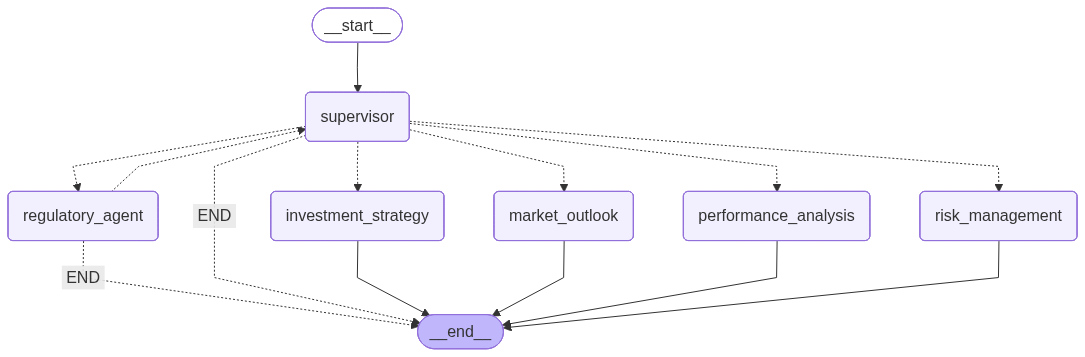


SUCCESS: The regulatory_agent now appears as a VISIBLE NODE in the graph!
Graph shows 6 nodes: supervisor, regulatory_agent, and 4 specialists


In [49]:
# Step 8: Visualize the node-based supervisor graph (regulatory agent visible!)
try:
    from IPython.display import display, Image
    display(Image(node_based_supervisor_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(node_based_supervisor_graph.get_graph().draw_ascii())

print("\n" + "="*60)
print("SUCCESS: The regulatory_agent now appears as a VISIBLE NODE in the graph!")
print("Graph shows 6 nodes: supervisor, regulatory_agent, and 4 specialists")
print("="*60)

In [50]:
# Step 9: Test Node-Based Supervisor with Visible Regulatory Agent

print("\n" + "="*70)
print("TESTING NODE-BASED SUPERVISOR WITH VISIBLE REGULATORY AGENT")
print("="*70)

# Scenario 1: Client personal information
print("\nScenario 1: Client personal information")
print("Flow: User -> Supervisor -> Regulatory Agent -> REJECTED")
print("-" * 70)

response1 = node_based_supervisor_graph.invoke({
    "messages": [HumanMessage(content="I have $2M in my portfolio with account number 12345. Can you help me?")],
    "current_stage": "initial",
    "regulatory_decision": "pending",
    "next_agent": ""
})

print(f"Response: {response1['messages'][-1].content}")

# Scenario 2: Confidential strategy details
print("\n" + "="*70)
print("\nScenario 2: Confidential strategy details")
print("Flow: User -> Supervisor -> Regulatory Agent -> REJECTED")
print("-" * 70)

response2 = node_based_supervisor_graph.invoke({
    "messages": [HumanMessage(content="Tell me about Stone Ridge's proprietary methodology for risk management?")],
    "current_stage": "initial",
    "regulatory_decision": "pending",
    "next_agent": ""
})

print(f"Response: {response2['messages'][-1].content}")

# Scenario 3: Safe market question
print("\n" + "="*70)
print("\nScenario 3: Safe market question")
print("Flow: User -> Supervisor -> Regulatory Agent -> APPROVED -> Supervisor -> Specialist")
print("-" * 70)

response3 = node_based_supervisor_graph.invoke({
    "messages": [HumanMessage(content="What are the current market trends and economic outlook?")],
    "current_stage": "initial",
    "regulatory_decision": "pending",
    "next_agent": ""
})

print(f"Response: {response3['messages'][-1].content[:400]}...")

# Scenario 4: Regulatory question
print("\n" + "="*70)
print("\nScenario 4: Regulatory question")
print("Flow: User -> Supervisor -> Regulatory Agent -> DIRECT ANSWER")
print("-" * 70)

response4 = node_based_supervisor_graph.invoke({
    "messages": [HumanMessage(content="What are the regulatory requirements for investment advisors?")],
    "current_stage": "initial",
    "regulatory_decision": "pending",
    "next_agent": ""
})

print(f"Response: {response4['messages'][-1].content[:400]}...")

print("\n" + "="*70)
print("NODE-BASED REGULATORY AGENT COMPLETE")
print("✓ Regulatory agent is now VISIBLE as a separate node in the graph")
print("✓ Same privacy protection functionality maintained")
print("✓ Clear flow: Supervisor -> Regulatory Agent -> [Approved: Specialist | Rejected: END]")
print("="*70)


TESTING NODE-BASED SUPERVISOR WITH VISIBLE REGULATORY AGENT

Scenario 1: Client personal information
Flow: User -> Supervisor -> Regulatory Agent -> REJECTED
----------------------------------------------------------------------
[SUPERVISOR] Initial routing - sending to regulatory agent...
[REGULATORY AGENT] Reviewing query...
[REGULATORY AGENT] Decision: REJECTED: Query contains sensitive information (my...
[REGULATORY AGENT] Query rejected - terminating
Response: [REGULATORY COMPLIANCE]

REJECTED: Query contains sensitive information (my portfolio). Cannot proceed.


Scenario 2: Confidential strategy details
Flow: User -> Supervisor -> Regulatory Agent -> REJECTED
----------------------------------------------------------------------
[SUPERVISOR] Initial routing - sending to regulatory agent...
[REGULATORY AGENT] Reviewing query...
[REGULATORY AGENT] Decision: REJECTED: Query contains sensitive information (pr...
[REGULATORY AGENT] Query rejected - terminating
Response: [REGULATORY 

---
#  🤝 Breakout Room #2
## Handoffs & Context Engineering

## Task 5: Agent Handoffs Pattern

The **Handoffs Pattern** allows agents to transfer control to each other based on the conversation context. Unlike the supervisor pattern, agents decide themselves when to hand off.

```
    User Question
         │
         ▼
    ┌──────────┐  "I need strategy help"  ┌──────────────┐
    │  Market  │ ────────────────────────► │  Investment  │
    │ Outlook  │                           │   Strategy   │
    │  Agent   │ ◄──────────────────────── │    Agent     │
    └──────────┘  "Back to market topics"  └──────────────┘
```

**Documentation:**
- [LangGraph Agent Handoffs](https://langchain-ai.github.io/langgraph/how-tos/agent-handoffs/)

In [ ]:
# Create handoff tools that agents can use to transfer control
# Each tool returns a special HANDOFF string that the graph will detect

@tool
def transfer_to_market_outlook(reason: str) -> str:
    """Transfer to Market Outlook Specialist for market trends, economic conditions, and macro environment questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:market_outlook:{reason}"

@tool
def transfer_to_investment_strategy(reason: str) -> str:
    """Transfer to Investment Strategy Specialist for portfolio positioning, asset allocation, and investment approach questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:investment_strategy:{reason}"

@tool
def transfer_to_risk_management(reason: str) -> str:
    """Transfer to Risk Management Specialist for risk factors, tail risks, hedging, and diversification questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:risk_management:{reason}"

@tool
def transfer_to_performance_analysis(reason: str) -> str:
    """Transfer to Performance Analysis Specialist for returns, benchmarks, and performance metrics questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:performance_analysis:{reason}"

print("Handoff tools created!")

In [ ]:
# Create agents with handoff capabilities (using create_agent)

market_outlook_handoff_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_market_outlook,
        transfer_to_investment_strategy,
        transfer_to_risk_management,
        transfer_to_performance_analysis
    ],
    system_prompt="""You are a Market Outlook Specialist. Answer questions about market trends, economic conditions, and the macro environment.
If the user's question is better suited for another specialist, use the appropriate transfer tool.
Always search the knowledge base before answering market outlook questions."""
)

investment_strategy_handoff_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_investment_strategy,
        transfer_to_market_outlook,
        transfer_to_risk_management,
        transfer_to_performance_analysis
    ],
    system_prompt="""You are an Investment Strategy Specialist. Answer questions about portfolio positioning, asset allocation, and investment philosophy.
If the user's question is better suited for another specialist, use the appropriate transfer tool.
Always search the knowledge base before answering investment strategy questions."""
)

risk_management_handoff_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_risk_info,
        transfer_to_market_outlook,
        transfer_to_investment_strategy,
        transfer_to_performance_analysis
    ],
    system_prompt="""You are a Risk Management Specialist. Answer questions about risk factors, tail risks, hedging, and diversification.
If the user's question is better suited for another specialist, use the appropriate transfer tool.
Always search the knowledge base before answering risk management questions."""
)

performance_analysis_handoff_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_performance_info,
        transfer_to_market_outlook,
        transfer_to_investment_strategy,
        transfer_to_risk_management
    ],
    system_prompt="""You are a Performance Analysis Specialist. Answer questions about investment returns, benchmarks, and performance metrics.
If the user's question is better suited for another specialist, use the appropriate transfer tool.
Always search the knowledge base before answering performance analysis questions."""
)

print("Handoff-enabled agents created (using create_agent)!")

In [ ]:
# Build the handoff graph with transfer limit to prevent infinite loops

class HandoffState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    current_agent: str
    transfer_count: int  # Track transfers to prevent infinite loops

MAX_TRANSFERS = 2  # Maximum number of handoffs allowed

def parse_handoff(content: str) -> tuple[bool, str, str]:
    """Parse a handoff from agent response."""
    if "HANDOFF:" in content:
        parts = content.split("HANDOFF:")[1].split(":")
        return True, parts[0], parts[1] if len(parts) > 1 else ""
    return False, "", ""

def create_handoff_node(agent, name: str):
    """Create a node that can handle handoffs."""
    def node(state: HandoffState):
        print(f"[{name.upper()} Agent] Processing...")
        result = agent.invoke({"messages": state["messages"]})
        last_message = result["messages"][-1]
        
        # Check for handoff in tool messages (only if under transfer limit)
        if state["transfer_count"] < MAX_TRANSFERS:
            for msg in result["messages"]:
                if hasattr(msg, 'content') and "HANDOFF:" in str(msg.content):
                    is_handoff, target, reason = parse_handoff(str(msg.content))
                    if is_handoff:
                        print(f"[{name.upper()}] Handing off to {target}: {reason}")
                        return {
                            "messages": [AIMessage(content=f"[{name}] Transferring to {target} specialist: {reason}")],
                            "current_agent": target,
                            "transfer_count": state["transfer_count"] + 1
                        }
        
        # No handoff (or limit reached), return final response
        response = AIMessage(
            content=f"[{name.upper()} SPECIALIST]\n\n{last_message.content}",
            name=name
        )
        print(f"[{name.upper()} Agent] Response complete.")
        return {"messages": [response], "current_agent": "done", "transfer_count": state["transfer_count"]}
    
    return node

# Create nodes
market_outlook_handoff_node = create_handoff_node(market_outlook_handoff_agent, "market_outlook")
investment_strategy_handoff_node = create_handoff_node(investment_strategy_handoff_agent, "investment_strategy")
risk_management_handoff_node = create_handoff_node(risk_management_handoff_agent, "risk_management")
performance_analysis_handoff_node = create_handoff_node(performance_analysis_handoff_agent, "performance_analysis")

print("Handoff nodes created!")

In [ ]:
# Build the handoff graph with initial routing (using GPT-5.2)

def entry_router(state: HandoffState):
    """Initial routing based on the user's question (using GPT-5.2)."""
    user_question = state['messages'][-1].content
    
    router_prompt = f"""Based on this question, which specialist should handle it?
Options: market_outlook, investment_strategy, risk_management, performance_analysis

Question: {user_question}

Respond with just the specialist name (one word or underscore-separated)."""
    
    response = supervisor_llm.invoke(router_prompt)
    agent = response.content.strip().lower()
    
    # Validate
    if agent not in ["market_outlook", "investment_strategy", "risk_management", "performance_analysis"]:
        agent = "market_outlook"  # Default to market outlook for general questions
    
    print(f"[Router GPT-5.2] Initial routing to: {agent}")
    return {"current_agent": agent, "transfer_count": 0}

def route_by_current_agent(state: HandoffState) -> str:
    """Route based on current_agent field."""
    return state["current_agent"]

# Build graph
handoff_workflow = StateGraph(HandoffState)

# Add nodes
handoff_workflow.add_node("router", entry_router)
handoff_workflow.add_node("market_outlook", market_outlook_handoff_node)
handoff_workflow.add_node("investment_strategy", investment_strategy_handoff_node)
handoff_workflow.add_node("risk_management", risk_management_handoff_node)
handoff_workflow.add_node("performance_analysis", performance_analysis_handoff_node)

# Entry point
handoff_workflow.add_edge(START, "router")

# Router to agents
handoff_workflow.add_conditional_edges(
    "router",
    route_by_current_agent,
    {
        "market_outlook": "market_outlook",
        "investment_strategy": "investment_strategy",
        "risk_management": "risk_management",
        "performance_analysis": "performance_analysis"
    }
)

# Agents can handoff to each other or end
for agent_name in ["market_outlook", "investment_strategy", "risk_management", "performance_analysis"]:
    handoff_workflow.add_conditional_edges(
        agent_name,
        route_by_current_agent,
        {
            "market_outlook": "market_outlook",
            "investment_strategy": "investment_strategy",
            "risk_management": "risk_management",
            "performance_analysis": "performance_analysis",
            "done": END
        }
    )

# Compile
handoff_graph = handoff_workflow.compile()

print("Handoff multi-agent system built!")

In [ ]:
# Visualize the handoff graph
try:
    from IPython.display import display, Image
    display(Image(handoff_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(handoff_graph.get_graph().draw_ascii())

In [ ]:
# Test the handoff system
print("Testing Handoff System")
print("=" * 50)

response = handoff_graph.invoke({
    "messages": [HumanMessage(content="I'm concerned about market volatility and want to understand the risk in my portfolio. What should I do?")],
    "current_agent": "",
    "transfer_count": 0
})

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

## Task 6: Building an Investment Agent Team

Now let's combine what we've learned to build a complete investment team that can:
1. Handle complex multi-domain investment questions
2. Search both the knowledge base and the web
3. Maintain conversation context
4. Provide comprehensive investment advisory guidance

In [ ]:
# Create a unified investment team with memory
from langgraph.checkpoint.memory import MemorySaver

# Add memory to the supervisor graph
memory = MemorySaver()

supervisor_with_memory = supervisor_workflow.compile(checkpointer=memory)

print("Supervisor with memory created!")

In [ ]:
# Test multi-turn conversation
thread_id = "investment-session-1"
config = {"configurable": {"thread_id": thread_id}}

print("Multi-turn Conversation Test")
print("=" * 50)

# First question
response1 = supervisor_with_memory.invoke(
    {"messages": [HumanMessage(content="What is Stone Ridge's investment philosophy?")]},
    config=config
)
print("\n[Turn 1 Response]:")
print(response1["messages"][-1].content[:500])

In [ ]:
# Follow-up question (should remember context)
response2 = supervisor_with_memory.invoke(
    {"messages": [HumanMessage(content="How do they manage risk in their portfolio?")]},
    config=config
)
print("\n[Turn 2 Response]:")
print(response2["messages"][-1].content[:500])

## Task 7: Context Engineering & Optimization

As conversations grow, we need to manage context carefully. Key principles:

1. **Context Window as Prime Real Estate**: Only include what's necessary
2. **Summarization**: Compress long conversations
3. **Selective Retrieval**: Don't retrieve everything, just what's relevant
4. **Context Rot**: More tokens doesn't mean better performance

In [ ]:
# Implement a context summarization function (using GPT-4o-mini for cost efficiency)
# This helps manage context length in multi-turn investment advisory conversations

def summarize_conversation(messages: list[BaseMessage], max_messages: int = 6) -> list[BaseMessage]:
    """Summarize older messages to manage context length."""
    if len(messages) <= max_messages:
        return messages
    
    # Keep the first message (original question) and last few messages
    old_messages = messages[1:-max_messages+1]
    recent_messages = messages[-max_messages+1:]
    
    # Summarize old messages
    summary_prompt = f"""Summarize this conversation history in 2-3 sentences, 
capturing the key topics discussed and any important decisions made:

{chr(10).join([f'{m.type}: {m.content[:200]}' for m in old_messages])}"""
    
    summary = specialist_llm.invoke(summary_prompt)
    
    # Return: first message + summary + recent messages
    return [
        messages[0],
        SystemMessage(content=f"[Previous conversation summary: {summary.content}]"),
        *recent_messages
    ]

print("Context summarization function created!")

In [ ]:
# Demonstrate context optimization
sample_messages = [
    HumanMessage(content="I want to understand Stone Ridge's investment approach"),
    AIMessage(content="Great question! Let's start with their philosophy."),
    HumanMessage(content="What about their risk management?"),
    AIMessage(content="Stone Ridge focuses on tail risk hedging..."),
    HumanMessage(content="How have they performed?"),
    AIMessage(content="Their performance has been..."),
    HumanMessage(content="What about portfolio construction?"),
    AIMessage(content="For portfolio construction..."),
    HumanMessage(content="What's their outlook for the current market?"),
]

print(f"Original messages: {len(sample_messages)}")

optimized = summarize_conversation(sample_messages, max_messages=4)
print(f"Optimized messages: {len(optimized)}")
print("\nOptimized conversation:")
for msg in optimized:
    print(f"  [{msg.type}]: {msg.content[:100]}...")

---
## Question #3:

Compare the **Supervisor pattern** and the **Handoffs pattern** we implemented. What are the key differences in how routing decisions are made? When would you choose one pattern over the other for an investment advisory system?

##### Answer:
*Your answer here*

## Question #4:

We discussed "Context Rot" - the idea that longer context doesn't always mean better performance. How does this principle apply to multi-agent investment advisory systems? What strategies can you use to manage context effectively when dealing with complex financial information?

##### Answer:
*Your answer here*

---
## Activity #2: Implement Hierarchical Teams

Build a **Hierarchical Agent System** where a top-level supervisor manages multiple team supervisors, each with their own specialist agents.

### Requirements:

1. Create an **Investment Director** (top-level supervisor using GPT-5.2) that:
   - Receives user questions and determines which team should handle it
   - Routes to either the "Markets Team" or "Strategy Team"
   - Aggregates final responses from teams

2. Create two **Team Supervisors**:
   - **Markets Team Lead**: Manages Market Outlook Agent and Performance Analysis Agent
   - **Strategy Team Lead**: Manages Investment Strategy Agent and Risk Management Agent

3. Implement the hierarchical routing:
   - User question -> Investment Director -> Team Lead -> Specialist Agent -> Response

4. Test with questions that require different teams:
   - "What is Stone Ridge's view on the current market environment?" (Markets team)
   - "How does Stone Ridge manage tail risk in its portfolios?" (Strategy team)

### Architecture:
```
                    ┌──────────────────────┐
                    │ Investment Director  │
                    │      (GPT-5.2)      │
                    └──────────┬───────────┘
                               │
              ┌────────────────┴────────────────┐
              │                                 │
              ▼                                 ▼
   ┌─────────────────────┐          ┌─────────────────────┐
   │   Markets Team      │          │   Strategy Team     │
   │     Lead            │          │     Lead            │
   └──────────┬──────────┘          └──────────┬──────────┘
              │                                 │
       ┌──────┴──────┐                   ┌──────┴──────┐
       │             │                   │             │
       ▼             ▼                   ▼             ▼
  ┌──────────┐ ┌────────────┐    ┌────────────┐ ┌──────────┐
  │ Market   │ │Performance │    │ Investment │ │   Risk   │
  │ Outlook  │ │ Analysis   │    │  Strategy  │ │Management│
  │  Agent   │ │   Agent    │    │   Agent    │ │  Agent   │
  └──────────┘ └────────────┘    └────────────┘ └──────────┘
```

**Documentation:**
- [LangGraph Hierarchical Teams](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/)

In [ ]:
### YOUR CODE HERE ###

# Step 1: Create Team Supervisors (using GPT-5.2 for routing)
# These manage routing within their teams

class TeamRouterOutput(BaseModel):
    """Team supervisor routing decision."""
    next: str  # The specialist to route to within the team
    reasoning: str

# Markets Team Lead
markets_team_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the Markets Team Lead.
Your team has two specialists:
- market_outlook: Handles market trends, economic conditions, and macro environment
- performance_analysis: Handles returns, benchmarks, and performance metrics

Route to the most appropriate specialist for the user's question."""),
    ("human", "Question: {question}")
])

# Strategy Team Lead  
strategy_team_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the Strategy Team Lead.
Your team has two specialists:
- investment_strategy: Handles portfolio positioning, asset allocation, and investment philosophy
- risk_management: Handles risk factors, tail risks, hedging, and diversification

Route to the most appropriate specialist for the user's question."""),
    ("human", "Question: {question}")
])

# Step 2: Create the Investment Director (top-level, using GPT-5.2)
class DirectorRouterOutput(BaseModel):
    """Director routing decision to teams."""
    team: Literal["markets", "strategy"]
    reasoning: str

director_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the Investment Director overseeing two teams:
- markets: Markets Team (market outlook, performance analysis)
- strategy: Strategy Team (investment strategy, risk management)

Route to the appropriate team based on the user's question."""),
    ("human", "Question: {question}")
])

# Step 3: Build the hierarchical graph
# Hint: You'll need nested graphs or a state that tracks the current level

# Step 4: Test the hierarchical system
# test_question = "What is Stone Ridge's view on the current market environment?"
# response = hierarchical_graph.invoke({"messages": [HumanMessage(content=test_question)]})
# print(response["messages"][-1].content)

---
## Summary

In this module, we:

1. **Understood Multi-Agent Systems**: When to use them and key patterns
2. **Built a Supervisor Pattern**: Central orchestrator routing to investment specialists
3. **Implemented Agent Handoffs**: Investment agents transferring control to each other
4. **Added Web Search**: Tavily for current market data alongside the Stone Ridge knowledge base
5. **Applied Context Engineering**: Managing context for optimal performance with financial information

### Key Takeaways:

- **Don't over-engineer**: Only add agents when you truly need specialization
- **Context is key**: Manage your context window carefully, especially with dense financial data
- **Patterns matter**: Choose the right pattern for your investment advisory use case

**Further Reading:**
- [Building Effective Agents (Anthropic)](https://www.anthropic.com/engineering/building-effective-agents)
- [Don't Build Multi-Agents (Cognition)](https://cognition.ai/blog/dont-build-multi-agents)
- [12-Factor Agents](https://github.com/humanlayer/12-factor-agents)